In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Cross Validation (CV)

* To evaluate how well a given algorithm will **generalize** when trained on a specific dataset
* The data is split into n equal chuncks. 
* In each run one chunck is taken as the test data and others for training data. 
* The R^2, mean, median, 95% confidence intervals calculated is more precise on 5 values. 
* Thus its called **k-fold** cross calidation or in general **n-fold CV**.

* It maximizes the amount of data that is used to train the model, as during the course of training, the model is not only trained, but also tested on all of the available data.

## CV on Regression

In [2]:
gapminder = pd.read_csv('regression/data/gm_2008_region.csv', header=0)
gapminder.head(2)

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5,Middle East & North Africa
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0,Sub-Saharan Africa


In [8]:
# data
X = gapminder.drop(['Region', 'life'], axis=1).values
y = gapminder.life.values

# init regression obj
reg = LinearRegression()

# compute 5-fold CV scores
cv_scores = cross_val_score(estimator=reg, X=X, y=y, cv=5)

# print the R^2 scores
print(cv_scores)

# compute mean R^2 score
print("\nThe average R^2 score is {:.2f}".format(np.mean(cv_scores)))

[0.81720569 0.82917058 0.90214134 0.80633989 0.94495637]

The average R^2 score is 0.86


The more folds we use the more computationally expensive it gets.

In [9]:
%timeit cross_val_score(reg, X, y, cv=3)

3.35 ms ± 45.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit cross_val_score(reg, X, y, cv=15)

15.8 ms ± 459 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## CV on Classifiaction

* stratiied k-fold cross-validaton
* the data is split such that the proportions between classes are the same in each fold as they are in the whole dataset

![title](classification/img/cv.png)

* if (binary) data has class labels 90% A and 10% B it can happen that data is split such that one fold contains labels only from class A
* stratification eliminates this possibility
* <font color='red'>**By not dividing data with train_test_split and usng cross_val_score striaght away the CV will stratify the data by default for classification algorithms**</font>

#### Compare stratified CV vs non-startified CV

In [46]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, random_state=7, stratify=y)

clf1 = LogisticRegression(solver='liblinear', multi_class='auto').fit(X_train, y_train)
clf2 = LogisticRegression(solver='liblinear', multi_class='auto').fit(X_train_s, y_train_s)

cv_3 = cross_val_score(clf1, X_test, y_test, cv=3)
cv_3_s = cross_val_score(clf2, X_test_s, y_test_s, cv=3)

print('CV scores non-strat: {}'.format(cv_3))
print('Mean CV non-strat: {:.2f}'.format(np.mean(cv_3)))
print('\nCV scores strat: {}'.format(cv_3_s))
print('Mean CV strat: {:.2f}'.format(np.mean(cv_3_s)))

CV scores non-strat: [0.85714286 0.76923077 1.        ]
Mean CV non-strat: 0.88

CV scores strat: [0.92857143 1.         0.91666667]
Mean CV strat: 0.95


# Grid Search

* One way to improve the models generaization further is to **tune** its parameters
* **Goal**: find parameter values that provide bets performance
* **Grid Searc** tries different combinations of parameters and provides the results for each combintion

<img src="classification/img/grid_cv.png" alt="Drawing" style="width: 300px;"/>

#### Grid Search Demo

In [52]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

gamma_space = np.logspace(-3, 2, 6)
C_space = np.logspace(-3, 2, 6)

best_score = 0
for gamma in gamma_space:
    for C in C_space:
        # SVC model with each gamma and C combo
        svm = SVC(C=C, gamma=gamma).fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}

print("Best score: {:.2f}".format(best_score))
print("Best Parameters: {}".format(best_parameters))

Best score: 0.97
Best Parameters: {'C': 100.0, 'gamma': 0.001}


In [57]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

gamma_space = np.logspace(-3, 2, 6)
C_space = np.logspace(-3, 2, 6)

param_grid = {'gamma':gamma_space,
             'C':C_space}

svm = SVC()
svm_cv = GridSearchCV(svm, param_grid=param_grid, cv=5, 
                      return_train_score=False, iid=False).fit(X_train, y_train)

print("Best score: {:.2f}".format(svm_cv.best_score_))
print('Best paramters: {}'.format(svm_cv.best_params_))

Best score: 0.97
Best paramters: {'C': 100.0, 'gamma': 0.01}


## Validation Set

* The model accuracy result 0.97 received previously would indicated our model performance is excellent yet it is stricktly speaking too optimistic/**WRONG**
* Even though we tested the paramter combinations on **test set** it does not carry over to totally new data.
* Because we used the test data to adjust the parameters we cannot assess model performance!
* One way to overcome this trouble is to split the data into 3 parts:
    * Training Set
    * Validation Set
    * Test Set
    
![title](classification/img/cv2.png)

* Use validation set for parameter tuning
* Use test set for model performance estimating

#### Validation Set Demo

##### With GridSearchCV

In [49]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, \
    random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, \
    y_trainval, random_state=1)

print('Training Set Size: {}, Validation Set Size: {}, Test Set Size: {}'.format(
    X_train.shape[0], X_val.shape[0], X_test.shape[0]))

gamma_space = np.logspace(-3, 2, 6)
C_space = np.logspace(-3, 2, 6)
param_grid = {'gamma':gamma_space, 'C':C_space}

svm = SVC(random_state=0)
svm_cv = GridSearchCV(svm, param_grid=param_grid, cv=3, 
                      return_train_score=False, iid=False).fit(X_train, y_train)

val_score = svm_cv.score(X_val, y_val)

# rebuild
svm2 = SVC(**svm_cv.best_params_).fit(X_trainval, y_trainval)
test_score = svm2.score(X_test, y_test)

print('\nBest score on validation set: {:.2f}'.format(val_score))
print('Best parameters: {}'.format(svm_cv.best_params_))
print('Model accuracy with best parameters and test set: {:.2f}'.format(test_score))

Training Set Size: 84, Validation Set Size: 28, Test Set Size: 38

Best score on validation set: 0.96
Best parameters: {'C': 10.0, 'gamma': 0.1}
Model accuracy with best parameters and test set: 0.97


### Plotting the scores as heatmap

In [51]:
results = pd.DataFrame(svm_cv.cv_results_)
results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001088,0.000138,0.000531,0.000035,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.344828,0.678571,0.333333,0.452244,0.160106,21
1,0.000827,0.000069,0.000451,0.000044,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.344828,0.678571,0.333333,0.452244,0.160106,21


In [57]:
scores = np.round(np.array(results.mean_test_score).reshape(6, 6), 2)
scores

array([[0.45, 0.45, 0.45, 0.45, 0.43, 0.4 ],
       [0.45, 0.45, 0.45, 0.45, 0.43, 0.4 ],
       [0.45, 0.45, 0.87, 0.93, 0.43, 0.4 ],
       [0.68, 0.89, 0.96, 0.99, 0.93, 0.51],
       [0.88, 0.98, 0.99, 0.99, 0.94, 0.55],
       [0.98, 0.99, 0.99, 0.99, 0.94, 0.55]])

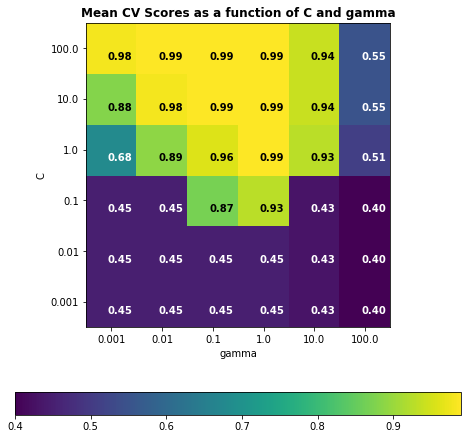

In [112]:
plt.figure(figsize=(8,8))
ax = plt.gca()

img = ax.pcolormesh(scores, cmap='viridis', )
img.update_scalarmappable()
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_xticks(np.arange(len(param_grid['gamma'])) +.5)
ax.set_yticks(np.arange(len(param_grid['C'])) +.5)
ax.set_xticklabels(param_grid['gamma'])
ax.set_yticklabels(param_grid['C'])
ax.set_title('Mean CV Scores as a function of C and gamma', weight='bold')
ax.set_aspect(1)
plt.colorbar(img, orientation='horizontal')

# adding text
for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
    fmt = "%0.2f"
    x, y = p.vertices[:-2, :].mean(0)
    if np.mean(color[:3]) > 0.5:
        c = 'k'
    else:
        c = 'w'
    ax.text(x, y, fmt % value, color=c, ha="center", va="center", weight='bold')
plt.show()

* the adjusted parameters are very important for obtaining good performance

##### Without GridSearchCV

In [48]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, \
    random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, \
    y_trainval, random_state=1)

print('Training Set Size: {}, Validation Set Size: {}, Test Set Size: {}'.format(
    X_train.shape[0], X_val.shape[0], X_test.shape[0]))

gamma_space = np.logspace(-3, 2, 6)
C_space = np.logspace(-3, 2, 6)
#param_grid = {'gamma':gamma_space, 'C':C_space}

best_score = 0
for gamma in gamma_space:
    for C in C_space:
        svm = SVC(C=C, gamma=gamma)
        svm.fit(X_train, y_train)
        score = svm.score(X_val, y_val)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}

# rebuild model with best params and evaluate with test set data
svm = SVC(**best_parameters).fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print('\nBest score on validation set: {:.2f}'.format(best_score))
print('Best parameters: {}'.format(best_parameters))
print('Model accuracy with best parameters and test set: {:.2f}'.format(test_score))

Training Set Size: 84, Validation Set Size: 28, Test Set Size: 38

Best score on validation set: 0.96
Best parameters: {'C': 10.0, 'gamma': 0.001}
Model accuracy with best parameters and test set: 0.92


* Since GridSearchCV found different gamma value for best describing the validation set, the end result here is little bit different.